# MLP Classifier

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV


In [2]:
# Function to divide the dataset into columns
def read_split_data(path):
    data = pd.read_csv(path, header = None)
    df = data[0].str.split(expand=True)
    
    df.columns = ["target", "col_1", "col_2", "col_3", "col_4", "col_5", "col_6", "id"]

    return df

In [3]:
# Function to separate the variables from targets and splitting the data into training/test set
def split(data):
    
    y = data['target']
    X = data.drop(columns=["target", "id"])

    return X, y

In [15]:
# Initializing empty lists to later store the values used in plots
train_accuracies = []
val_accuracies = []
train_MSEs = []
val_MSEs = []

# Deciding a number of epochs
epochs = 340

In [16]:
def val_train_split(folds, x, y, grid, epochs):
    for train, val in folds.split(x, y):
        
        #Splitting the data into validation and training sets
        X_tr, X_val = x[train], x[val]
        y_tr, y_val = y.iloc[train], y.iloc[val]

        #Setting the type of the data to int to stabilize it
        y_tr = y_tr.astype(int)
        y_val = y_val.astype(int)

        #Using the grid search to find the best parameters
        grid_results = grid.fit(X_tr, y_tr)
        best_parameters = grid_results.best_params_
        best_model = MLPClassifier(**best_parameters, random_state=42)
        
        #Storing the metrics for current fold to later use in plots
        fold_train_accuracies = []
        fold_val_accuracies = []  
        fold_train_MSE = []
        fold_val_MSE = []        

        #Incremental training
        for epoch in range(1, epochs+1):

            best_model.partial_fit(X_tr, y_tr, classes = np.unique(y_tr))

            #Predictions
            y_train_pred = best_model.predict(X_tr)
            y_val_pred = best_model.predict(X_val)

            #Compute accuracy to use in plots
            train_accuracy = accuracy_score(y_tr, y_train_pred)
            val_accuracy = accuracy_score(y_val, y_val_pred)

            #Computing the mean squared errors
            train_MSE = mean_squared_error(y_tr, y_train_pred)
            val_MSE = mean_squared_error(y_val, y_val_pred)

            #Saving the values for each fold
            fold_train_accuracies.append(train_accuracy)
            fold_val_accuracies.append(val_accuracy)
            fold_train_MSE.append(train_MSE)
            fold_val_MSE.append(val_MSE)

        # Saving the metrics for each fold
        train_accuracies.append(fold_train_accuracies)
        val_accuracies.append(fold_val_accuracies)
        train_MSEs.append(fold_train_MSE)
        val_MSEs.append(fold_val_MSE)

        return  best_model


# Task \#3

### Data prep

In [17]:
# Reading the csv file
path_train_1 = "../data/monks-3.train"
train_1 = read_split_data(path_train_1)

train_1.head()

# Splitting the training dataset
X_train, y_train = split(train_1)

In [18]:
# Reading the csv file
path_test_1 = "../data/monks-3.test"
test_1 = read_split_data(path_test_1)

test_1.head()

# Splitting the test dataset
X_test, y_test = split(test_1)

In [19]:
# Encoding the variables 
encoder = OneHotEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.fit_transform(X_test)

In [20]:
# Shape of the data
print(f"Monk 1 [TRAIN]: " + str(X_train.shape))
print(f"Monk 1 [TEST]: " + str(X_test.shape))

Monk 1 [TRAIN]: (122, 17)
Monk 1 [TEST]: (432, 17)


### Building the Model and Training

In [21]:
#Splitting the folds
folds = KFold(n_splits = 5, shuffle = True, random_state=42)

#List of parameters to try
MLP_params = {'solver' : ['adam', 'sgd'],
              'learning_rate_init' : [0.01, 0.3],
              'activation': ['relu', 'tanh', 'logistic'],
              'hidden_layer_sizes': [(3,), (5,), (10,)],
              'momentum' : [0.3, 0.7],
              'nesterovs_momentum': [True, False],
              'shuffle': [True],
              'alpha': [0.01, 0.5], #Adding the regularization for the third task, since there is more noise
              'max_iter' : [1000] }

#Grid Search
MLP_grid = GridSearchCV(estimator=MLPClassifier(), 
                        param_grid=MLP_params, 
                        n_jobs=-1, 
                        cv=folds,
                        refit = 'accuracy',
                        verbose=2)

In [22]:
# Selecting the best model to use on prediction
best_model = val_train_split(folds, X_train, y_train, MLP_grid, epochs)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


In [23]:
# Calculating the mean for training and validation accuracies
mean_train_accuracies = np.mean(train_accuracies, axis=0)
mean_val_accuracies = np.mean(val_accuracies, axis=0)

#Calculating the mean for training and validation mean squared errors
mean_train_MSE = np.mean(train_MSEs, axis = 0)
mean_val_MSE = np.mean(val_MSEs, axis = 0)

# Accuracy of the model on training and validation
print("Accuracy and Mean Squared Error of the model:")
print("Mean Training Accuracy: ", np.mean(mean_train_accuracies))
print("Mean Validation Accuracy: ", np.mean(mean_val_accuracies))
print("Mean Training Loss: ", np.mean(mean_train_MSE))
print("Mean Validation Loss: ", np.mean(mean_val_MSE))

Accuracy and Mean Squared Error of the model:
Mean Training Accuracy:  0.9602789569436023
Mean Validation Accuracy:  0.9116470588235295
Mean Training Loss:  0.039721043056397815
Mean Validation Loss:  0.08835294117647058


### Visualization

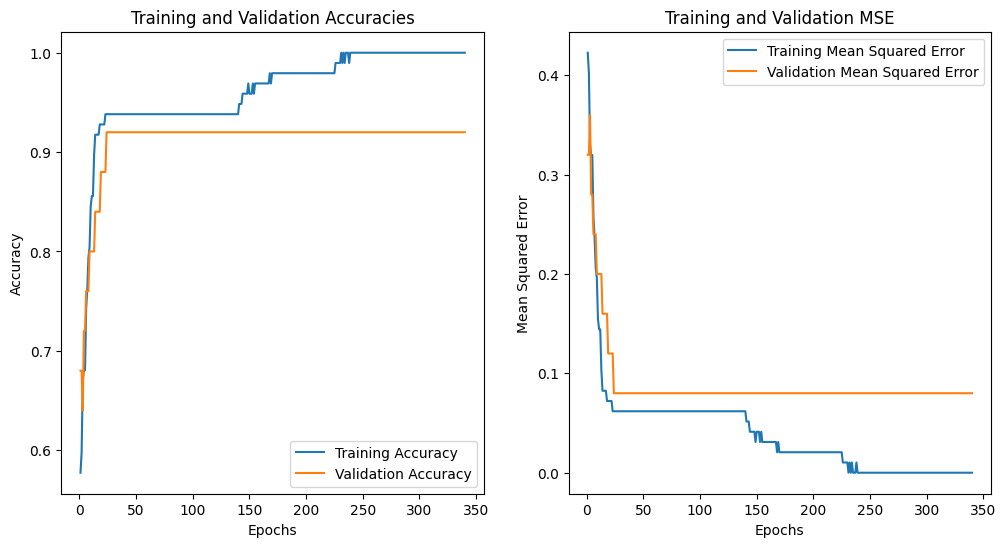

In [24]:
# Plot the learning curves
plt.figure(figsize=(12, 6))

# Plotting accuracies
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), mean_train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), mean_val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting losses
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), mean_train_MSE, label='Training Mean Squared Error')
plt.plot(range(1, epochs + 1), mean_val_MSE, label='Validation Mean Squared Error')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()

### Prediction on test set

In [25]:
y_pred_test = best_model.predict(X_test)

#Making the data consistent
y_test = y_test.astype(int)
y_pred_test = y_pred_test.astype(int)

#Predicting on test set
print(accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

0.9652777777777778
              precision    recall  f1-score   support

           0       0.94      1.00      0.96       204
           1       1.00      0.94      0.97       228

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432

